<a href="https://colab.research.google.com/github/yyajima21/nn_tutorial/blob/dev/nn_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This tutorial covers a content from "WHAT IS TORCH.NN REALLY?"
Link: https://pytorch.org/tutorials/beginner/nn_tutorial.html

# Load data

In [0]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [0]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

# Check train dataset

(50000, 784)


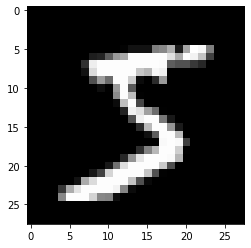

In [0]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

# Convert to tensors from numpy arrays

In [0]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


# Neural Networks without nn modules

In [0]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [0]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [0]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.3938, -1.4704, -1.9459, -2.9520, -2.4966, -2.3755, -2.9553, -2.9054,
        -2.9974, -1.8855], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [0]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [0]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.4920, grad_fn=<NegBackward>)


In [0]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [0]:
print(accuracy(preds, yb))

tensor(0.0625)


In [0]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [0]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0670, grad_fn=<NegBackward>) tensor(1.)


# Refactor using nn.Module

In [0]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [0]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0670, grad_fn=<NllLossBackward>) tensor(1.)


In [0]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [0]:
model = Mnist_Logistic()

In [0]:
print(loss_func(model(xb), yb))

tensor(2.4168, grad_fn=<NllLossBackward>)


In [0]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [0]:
print(loss_func(model(xb), yb))

tensor(0.0809, grad_fn=<NllLossBackward>)


# Refactor using nn.Linear

In [0]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [0]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.4421, grad_fn=<NllLossBackward>)


In [0]:
fit()
print(loss_func(model(xb), yb))

tensor(0.0814, grad_fn=<NllLossBackward>)


# Refactor using optim

In [0]:
from torch import optim

In [0]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3390, grad_fn=<NllLossBackward>)
tensor(0.0820, grad_fn=<NllLossBackward>)
